In [11]:
pip install scikit-learn


   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   -- ------------------------------------- 0.8/11.1 MB 5.2 MB/s eta 0:00:02
   ----- ---------------------------------- 1.6/11.1 MB 6.8 MB/s eta 0:00:02
   ---------- ----------------------------- 2.9/11.1 MB 5.0 MB/s eta 0:00:02
   --------------- ------------------------ 4.2/11.1 MB 5.4 MB/s eta 0:00:02
   --------------------- ------------------ 6.0/11.1 MB 6.6 MB/s eta 0:00:01
   -------------------------- ------------- 7.3/11.1 MB 6.5 MB/s eta 0:00:01
   -------------------------- ------------- 7.3/11.1 MB 6.5 MB/s eta 0:00:01
   -------------------------- ------------- 7.3/11.1 MB 6.5 MB/s eta 0:00:01
   -------------------------------- ------- 8.9/11.1 MB 5.0 MB/s eta 0:00:01
   ---------------------------------- ----- 9.4/11.1 MB 4.7 MB/s eta 0:00:01
   ------------------------------------- -- 10.5/11.1 MB 4.7 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 4.7 MB/s eta 0:00:00
   -


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import re
import folium
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')


In [13]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## Load the data

In [29]:
def load_latest_data(prefix='unegui_data_'):
    """Load the most recent CSV file with the given prefix"""
    files = [f for f in os.listdir('.') if f.startswith(prefix) and f.endswith('.csv')]
    if not files:
        raise FileNotFoundError(f"No CSV files with prefix '{prefix}' found")
    
    latest_file = max(files)
    print(f"Loading data from {latest_file}")
    return pd.read_csv(latest_file, encoding='utf-8-sig')



In [30]:
# Try to load both rental and sales data if available
try:
    rental_df = load_latest_data(prefix='unegui_data_')
    print(f"Loaded rental data: {rental_df.shape[0]} records")
except FileNotFoundError as e:
    print(f"Warning: {e}")
    rental_df = None

try:
    # Assuming your sales data has a different prefix
    sales_df = load_latest_data(prefix='unegui_sales_data_')
    print(f"Loaded sales data: {sales_df.shape[0]} records")
except FileNotFoundError as e:
    print(f"Warning: {e}")
    sales_df = None

In [31]:

# Combine rental and sales data into one (if both are available)
if rental_df is not None and sales_df is not None:
    rental_df['Type'] = 'Rental'
    sales_df['Type'] = 'Sale'
    combined_df = pd.concat([rental_df, sales_df], ignore_index=True)
elif rental_df is not None:
    rental_df['Type'] = 'Rental'
    combined_df = rental_df
elif sales_df is not None:
    sales_df['Type'] = 'Sale'


In [32]:
combined_df = sales_df

In [27]:
from datetime import datetime, timedelta  # Added timedelta import


In [35]:

# Convert 'Scraped_date' to datetime
combined_df['Scraped_date'] = pd.to_datetime(combined_df['Scraped_date'], errors='coerce')

# Function to fix 'Нийтэлсэн' (Posted Date) based on 'Scraped_date'
def fix_posted_date(row):
    # If 'Нийтэлсэн' contains 'Өнөөдөр' (Today), replace with today's date
    if 'Өнөөдөр' in str(row['Нийтэлсэн']):
        return row['Scraped_date'].replace(hour=datetime.now().hour, minute=datetime.now().minute, second=0)
    # If 'Нийтэлсэн' contains 'Өчигдөр' (Yesterday), replace with yesterday's date
    elif 'Өчигдөр' in str(row['Нийтэлсэн']):
        yesterday = datetime.now() - timedelta(1)
        return yesterday.replace(hour=datetime.now().hour, minute=datetime.now().minute, second=0)
    else:
        # Otherwise, just convert the 'Нийтэлсэн' date
        return pd.to_datetime(row['Нийтэлсэн'], errors='coerce')

# Apply the function to the 'Нийтэлсэн' (Posted Date) column
combined_df['Fixed Posted Date'] = combined_df.apply(fix_posted_date, axis=1)

# Check the result
print(combined_df[['Нийтэлсэн', 'Fixed Posted Date', 'Scraped_date']].head())

TypeError: 'NoneType' object is not subscriptable

In [ ]:
def extract_location_details(combined_df):
    combined_df = combined_df.copy()

    # Split the 'Байршил' column into district and sub-district/area
    combined_df[['District', 'Sub-District']] = combined_df['Байршил'].str.split(',', n=1, expand=True)

    # Clean the District and Sub-District columns (strip leading/trailing whitespaces)
    combined_df['District'] = combined_df['District'].str.strip()
    combined_df['Sub-District'] = combined_df['Sub-District'].str.strip()

    return combined_df

# Apply the function to extract location details
combined_df = extract_location_details(combined_df)

# Display a sample to ensure it worked
print(combined_df[['Байршил', 'District', 'Sub-District']].head())


In [ ]:
def extract_primary_district(combined_df):
    combined_df = combined_df.copy()
    combined_df['PrimaryDistrict'] = combined_df['Байршил'].str.split(',').str[0].str.strip()
    return combined_df


In [ ]:
# Apply the function to extract the primary district
combined_df = extract_primary_district(combined_df)

# Check the first few rows to see if the 'PrimaryDistrict' column was added
print(combined_df.head())


In [ ]:
def clean_sub_district(combined_df):
    combined_df = combined_df.copy()

    # Remove extra spaces
    combined_df['Sub-District'] = combined_df['Sub-District'].str.strip()

    # Handle NaN or non-string values and remove everything before the last comma
    combined_df['Sub-District'] = combined_df['Sub-District'].apply(lambda x: x.rsplit(',', 1)[-1].strip() if isinstance(x, str) else x)

    return combined_df

# Apply the function to clean the Sub-District column
combined_df = clean_sub_district(combined_df)

# Display a sample to check the cleaned Sub-District
print(combined_df[['Байршил', 'District', 'Sub-District']].head())


In [ ]:
# Get the number of unique Sub-Districts
unique_sub_districts = combined_df['Sub-District'].nunique()

# Print the number of unique Sub-Districts
print(f'Number of unique Sub-Districts: {unique_sub_districts}')


In [ ]:
combined_df

# Analysis

In [ ]:
buying_df.to_excel("buying_table.xlsx", index=False)


In [ ]:
import pandas as pd

# Example cleaning steps
buying_df["Талбай_m2"] = buying_df["Талбай"].str.replace(" м²", "").str.replace(",", ".").astype(float)
buying_df["ӨрөөнийТоо"] = buying_df["ӨрөөнийТоо"].str.extract(r"(\d+)").astype(float)
buying_df["Үнэ"] = pd.to_numeric(buying_df["Үнэ"], errors="coerce")
buying_df["Scraped_date"] = pd.to_datetime(buying_df["Scraped_date"], errors="coerce")
buying_df["Fixed Posted Date"] = pd.to_datetime(buying_df["Fixed Posted Date"], errors="coerce")

# Price per square meter
buying_df["price_per_m2"] = buying_df["Үнэ"] / buying_df["Талбай_m2"]

# Split complex location into 3 columns (optional)
buying_df[["PrimaryDistrict1", "PrimaryDistrict2", "PrimaryKhoroo"]] = buying_df["Байршил"].str.split(",", expand=True, n=2)


In [ ]:
avg_price = buying_df.groupby("Sub-District")["Үнэ"].mean().sort_values(ascending=False)
print(avg_price)


In [22]:
room_counts = buying_df["ӨрөөнийТоо"].value_counts().sort_index()
print(room_counts)


ӨрөөнийТоо
1.0     679
2.0    4026
3.0    4203
4.0    1996
5.0     490
Name: count, dtype: int64


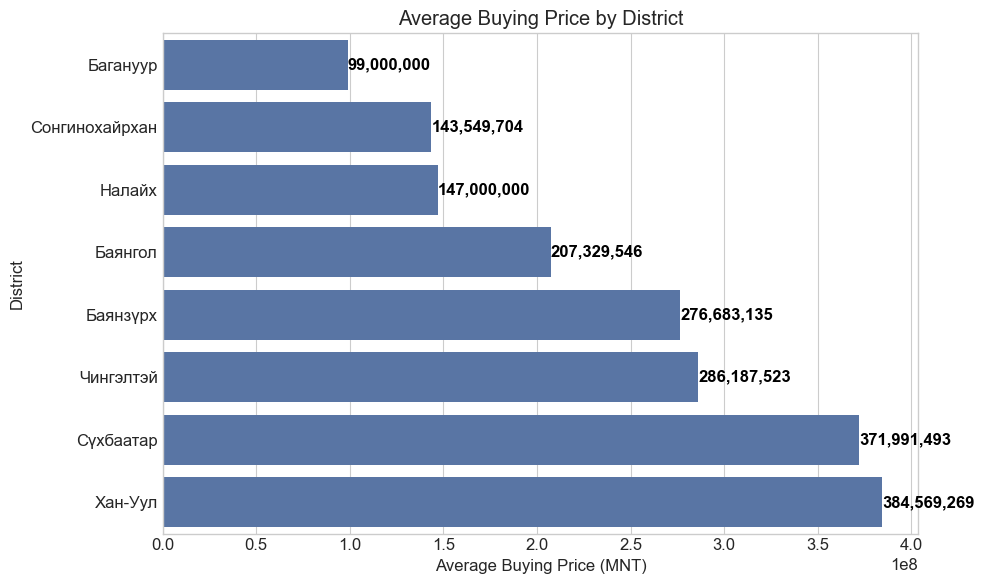

In [16]:
# Filter for buying properties (assuming 'Type' column indicates 'Sale' for buy listings)
buying_df = combined_df[combined_df['Type'] == 'Sale']

# Ensure 'Үнэ' is numeric
buying_df['Үнэ'] = pd.to_numeric(buying_df['Үнэ'], errors='coerce')

# Group by 'PrimaryDistrict' and calculate the average purchase price
district_avg_buying_price = buying_df.groupby('PrimaryDistrict')['Үнэ'].mean()

# Sort the districts by average price in ascending order
district_avg_buying_price_sorted = district_avg_buying_price.sort_values()

# Plotting
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=district_avg_buying_price_sorted.values, y=district_avg_buying_price_sorted.index, orient='h')

# Add labels and title
plt.title('Average Buying Price by District')
plt.ylabel('District')
plt.xlabel('Average Buying Price (MNT)')

# Adding the actual amounts (average prices) to the bars
for i, v in enumerate(district_avg_buying_price_sorted.values):
    ax.text(v + 50000, i, f'{v:,.0f}', va='center', color='black', fontweight='bold')

plt.tight_layout()

# Show the plot
plt.show()


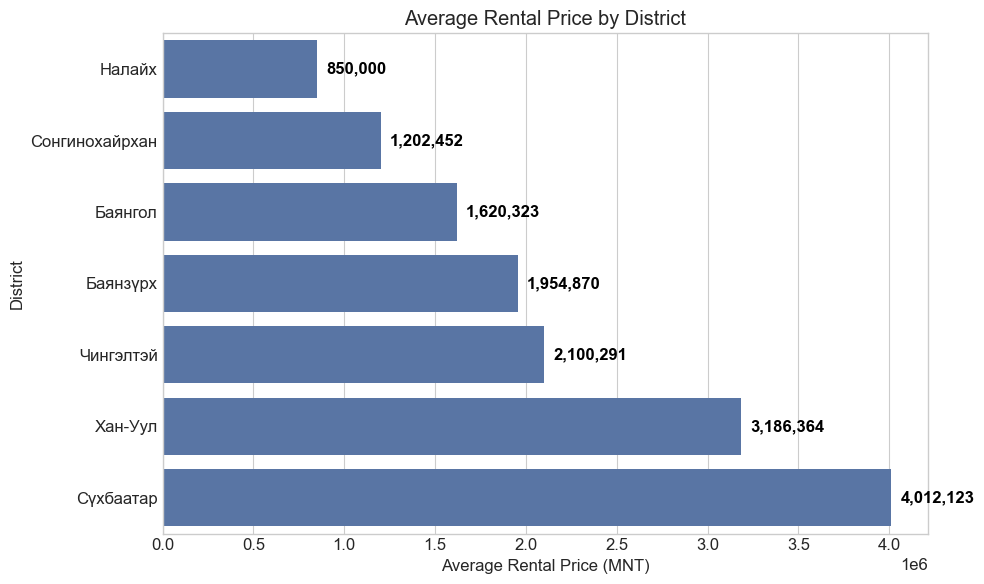

In [27]:
# Filter for rental properties (assuming 'Type' column indicates 'Rental' for rent listings)
rental_df = combined_df[combined_df['Type'] == 'Rental']

# Ensure 'Үнэ' is numeric
rental_df['Үнэ'] = pd.to_numeric(rental_df['Үнэ'], errors='coerce')

# Group by 'PrimaryDistrict' and calculate the average rental price
district_avg_rental_price = rental_df.groupby('PrimaryDistrict')['Үнэ'].mean()

# Sort the districts by average price in ascending order
district_avg_rental_price_sorted = district_avg_rental_price.sort_values()

# Plotting
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=district_avg_rental_price_sorted.values, y=district_avg_rental_price_sorted.index, orient='h')

# Add labels and title
plt.title('Average Rental Price by District')
plt.ylabel('District')
plt.xlabel('Average Rental Price (MNT)')

# Adding the actual amounts (average prices) to the bars
for i, v in enumerate(district_avg_rental_price_sorted.values):
    ax.text(v + 50000, i, f'{v:,.0f}', va='center', color='black', fontweight='bold')

plt.tight_layout()

# Show the plot
plt.show()


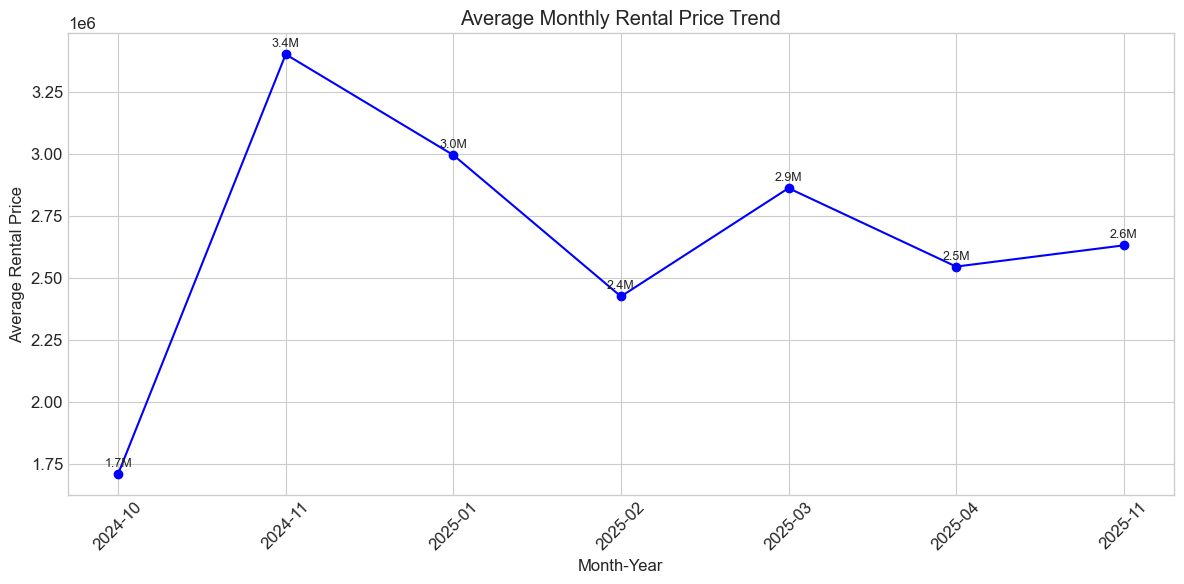

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ensure 'Fixed Posted Date' is in datetime format
combined_df['Fixed Posted Date'] = pd.to_datetime(combined_df['Fixed Posted Date'], errors='coerce')

# Filter rental properties (assuming 'Type' column indicates 'Rental' for rent listings)
rental_df = combined_df[combined_df['Type'] == 'Rental']

# Ensure 'Үнэ' is numeric
rental_df['Үнэ'] = pd.to_numeric(rental_df['Үнэ'], errors='coerce')

# Group by 'Year-Month' to get the average rental price for each month
rental_df['Year-Month'] = rental_df['Fixed Posted Date'].dt.to_period('M')

# Calculate the average price for each month
price_trend_monthly = rental_df.groupby('Year-Month')['Үнэ'].mean()

# Function to format numbers to short notation (e.g., 1500000 -> 1.5M)
def format_price(price):
    if price >= 1_000_000:
        return f'{price/1_000_000:.1f}M'
    elif price >= 1000:
        return f'{price/1000:.1f}K'
    else:
        return f'{price}'

# Plotting the price trend over time by month
plt.figure(figsize=(12, 6))
plt.plot(price_trend_monthly.index.astype(str), price_trend_monthly.values, marker='o', linestyle='-', color='b')

# Add labels and title
plt.title('Average Monthly Rental Price Trend')
plt.xlabel('Month-Year')
plt.ylabel('Average Rental Price')

# Annotate the actual prices (formatted) on the plot
for i, txt in enumerate(price_trend_monthly.values):
    formatted_price = format_price(txt)
    plt.annotate(formatted_price, (price_trend_monthly.index.astype(str)[i], price_trend_monthly.values[i]), 
                 textcoords="offset points", xytext=(0, 5), ha='center', fontsize=9)

# Format the x-axis to show months and years more clearly
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


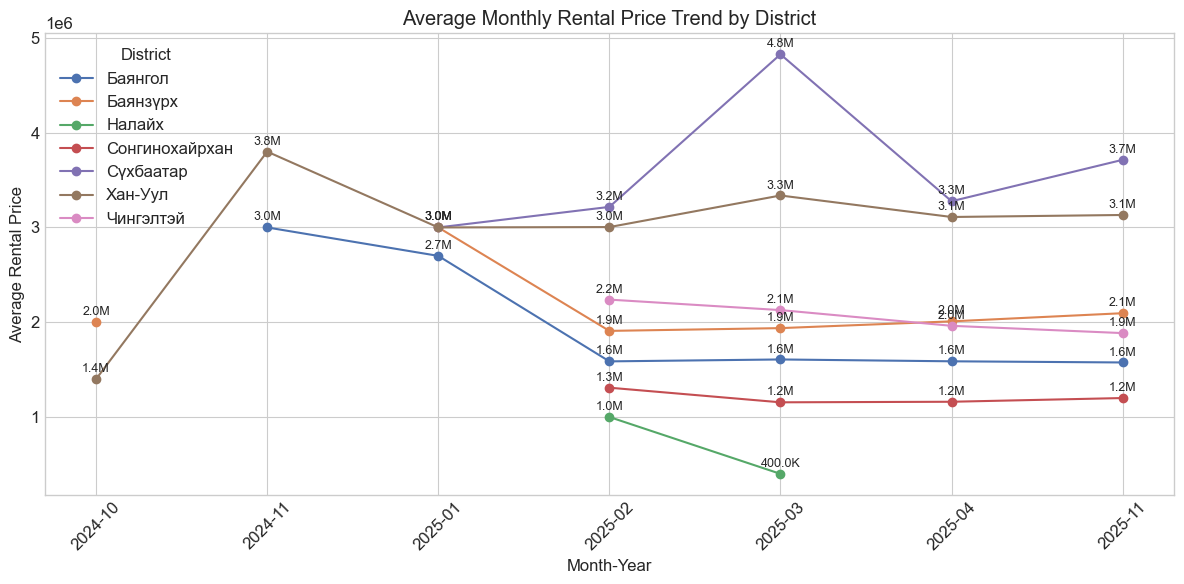

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ensure 'Fixed Posted Date' is in datetime format
combined_df['Fixed Posted Date'] = pd.to_datetime(combined_df['Fixed Posted Date'], errors='coerce')

# Filter rental properties (assuming 'Type' column indicates 'Rental' for rent listings)
rental_df = combined_df[combined_df['Type'] == 'Rental']

# Ensure 'Үнэ' is numeric
rental_df['Үнэ'] = pd.to_numeric(rental_df['Үнэ'], errors='coerce')

# Group by 'Year-Month' and 'PrimaryDistrict' to get the average rental price for each district per month
rental_df['Year-Month'] = rental_df['Fixed Posted Date'].dt.to_period('M')

# Calculate the average price for each district by month
price_trend_districts = rental_df.groupby(['Year-Month', 'PrimaryDistrict'])['Үнэ'].mean().unstack()

# Function to format numbers to short notation (e.g., 1500000 -> 1.5M)
def format_price(price):
    if price >= 1_000_000:
        return f'{price/1_000_000:.1f}M'
    elif price >= 1000:
        return f'{price/1000:.1f}K'
    else:
        return f'{price}'

# Plotting the price trends for each district
plt.figure(figsize=(12, 6))

# Plot each district's price trend
for district in price_trend_districts.columns:
    plt.plot(price_trend_districts.index.astype(str), price_trend_districts[district], marker='o', linestyle='-', label=district)

# Add labels and title
plt.title('Average Monthly Rental Price Trend by District')
plt.xlabel('Month-Year')
plt.ylabel('Average Rental Price')

# Annotate the actual prices (formatted) on the plot for each district
for district in price_trend_districts.columns:
    for i, txt in enumerate(price_trend_districts[district].values):
        formatted_price = format_price(txt)
        plt.annotate(formatted_price, (price_trend_districts.index.astype(str)[i], price_trend_districts[district].values[i]), 
                     textcoords="offset points", xytext=(0, 5), ha='center', fontsize=9)

# Format the x-axis to show months and years more clearly
plt.xticks(rotation=45)

# Display legend
plt.legend(title="District")

# Show the plot
plt.tight_layout()
plt.show()


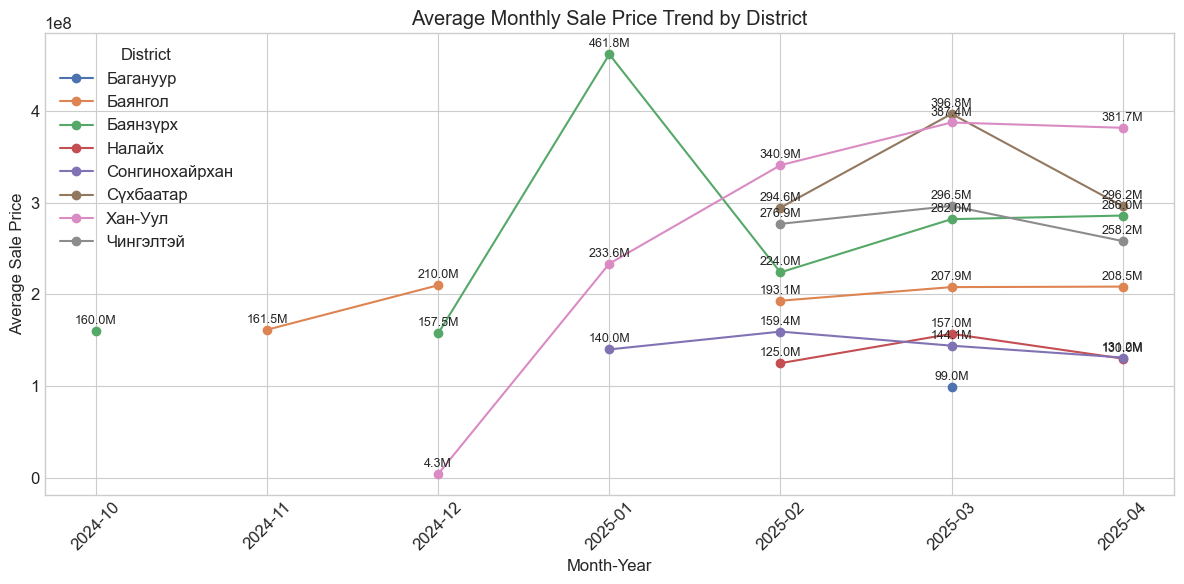

In [32]:
# Filter sale properties (assuming 'Type' column indicates 'Sale' for sale listings)
sale_df = combined_df[combined_df['Type'] == 'Sale']

# Ensure 'Үнэ' is numeric (in case there are any non-numeric values)
sale_df['Үнэ'] = pd.to_numeric(sale_df['Үнэ'], errors='coerce')

# Group by 'Year-Month' and 'PrimaryDistrict' to get the average sale price for each district per month
sale_df['Year-Month'] = sale_df['Fixed Posted Date'].dt.to_period('M')

# Calculate the average price for each district by month
price_trend_districts_sales = sale_df.groupby(['Year-Month', 'PrimaryDistrict'])['Үнэ'].mean().unstack()

# Plotting the price trends for each district
plt.figure(figsize=(12, 6))

# Plot each district's price trend
for district in price_trend_districts_sales.columns:
    plt.plot(price_trend_districts_sales.index.astype(str), price_trend_districts_sales[district], marker='o', linestyle='-', label=district)

# Add labels and title
plt.title('Average Monthly Sale Price Trend by District')
plt.xlabel('Month-Year')
plt.ylabel('Average Sale Price')

# Annotate the actual prices (formatted) on the plot for each district
for district in price_trend_districts_sales.columns:
    for i, txt in enumerate(price_trend_districts_sales[district].values):
        formatted_price = format_price(txt)
        plt.annotate(formatted_price, (price_trend_districts_sales.index.astype(str)[i], price_trend_districts_sales[district].values[i]), 
                     textcoords="offset points", xytext=(0, 5), ha='center', fontsize=9)

# Format the x-axis to show months and years more clearly
plt.xticks(rotation=45)

# Display legend
plt.legend(title="District")

# Show the plot
plt.tight_layout()
plt.show()


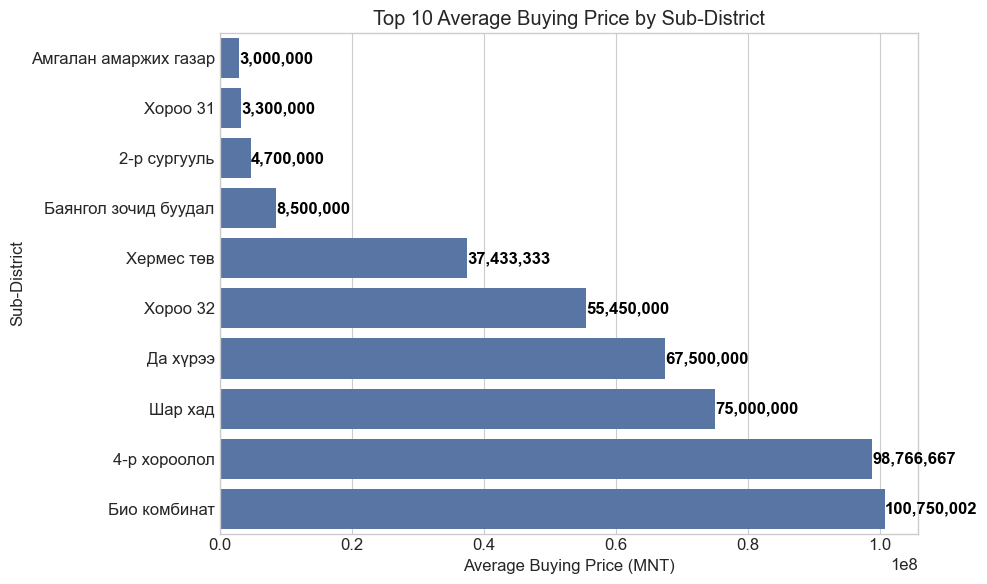

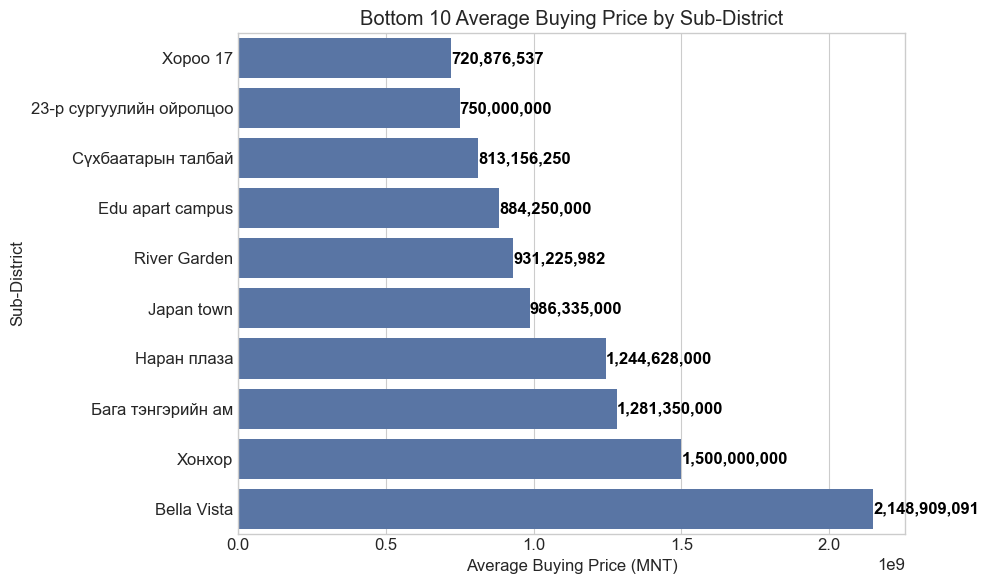

In [42]:
# Filter for buying properties (assuming 'Type' column indicates 'Sale' for buy listings)
buying_df = combined_df[combined_df['Type'] == 'Sale']

# Ensure 'Үнэ' is numeric
buying_df['Үнэ'] = pd.to_numeric(buying_df['Үнэ'], errors='coerce')

# Group by 'Sub-District' and calculate the average purchase price
sub_district_avg_buying_price = buying_df.groupby('Sub-District')['Үнэ'].mean()

# Sort the sub-districts by average price in ascending order
sub_district_avg_buying_price_sorted = sub_district_avg_buying_price.sort_values()

# Get the top 10 and bottom 10 sub-districts
top_10_sub_districts = sub_district_avg_buying_price_sorted.head(10)
bottom_10_sub_districts = sub_district_avg_buying_price_sorted.tail(10)

# Plotting the Top 10 Sub-Districts
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_10_sub_districts.values, y=top_10_sub_districts.index, orient='h')

# Add labels and title
plt.title('Top 10 Average Buying Price by Sub-District')
plt.ylabel('Sub-District')
plt.xlabel('Average Buying Price (MNT)')

# Adding the actual amounts (average prices) to the bars
for i, v in enumerate(top_10_sub_districts.values):
    ax.text(v + 50000, i, f'{v:,.0f}', va='center', color='black', fontweight='bold')

plt.tight_layout()
plt.show()

# Plotting the Bottom 10 Sub-Districts
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=bottom_10_sub_districts.values, y=bottom_10_sub_districts.index, orient='h')

# Add labels and title
plt.title('Bottom 10 Average Buying Price by Sub-District')
plt.ylabel('Sub-District')
plt.xlabel('Average Buying Price (MNT)')

# Adding the actual amounts (average prices) to the bars
for i, v in enumerate(bottom_10_sub_districts.values):
    ax.text(v + 50000, i, f'{v:,.0f}', va='center', color='black', fontweight='bold')

plt.tight_layout()
plt.show()


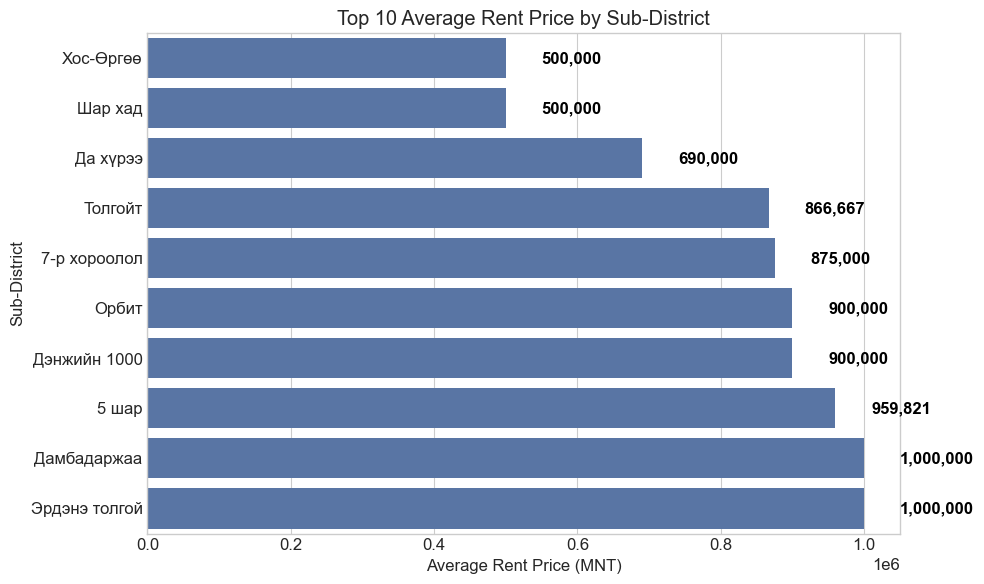

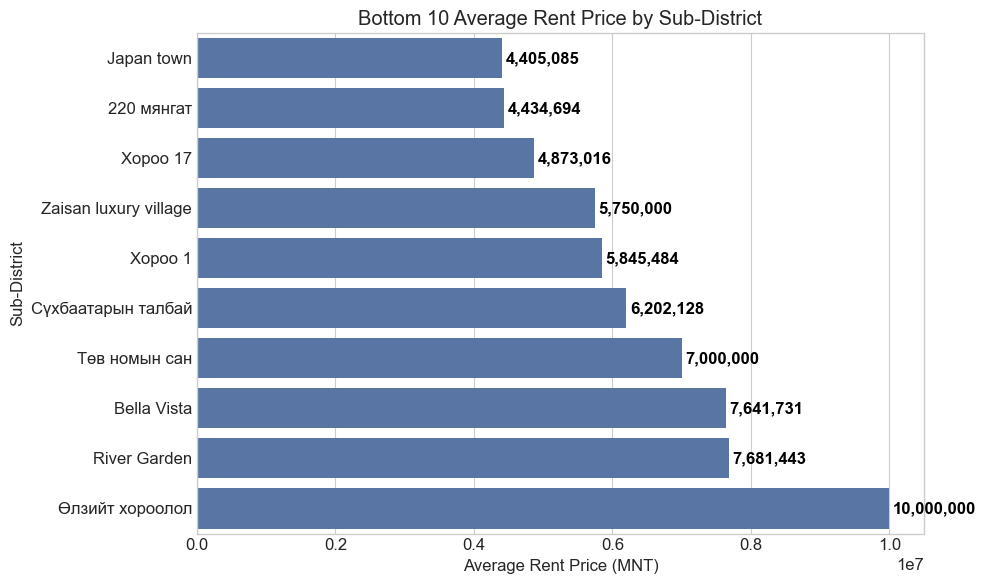

In [43]:
# Filter for renting properties (assuming 'Type' column indicates 'Rental' for rent listings)
renting_df = combined_df[combined_df['Type'] == 'Rental']

# Ensure 'Үнэ' is numeric
renting_df['Үнэ'] = pd.to_numeric(renting_df['Үнэ'], errors='coerce')

# Group by 'Sub-District' and calculate the average rental price
sub_district_avg_rent_price = renting_df.groupby('Sub-District')['Үнэ'].mean()

# Sort the sub-districts by average price in ascending order
sub_district_avg_rent_price_sorted = sub_district_avg_rent_price.sort_values()

# Get the top 10 and bottom 10 sub-districts
top_10_sub_districts_rent = sub_district_avg_rent_price_sorted.head(10)
bottom_10_sub_districts_rent = sub_district_avg_rent_price_sorted.tail(10)

# Plotting the Top 10 Sub-Districts for Rent
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_10_sub_districts_rent.values, y=top_10_sub_districts_rent.index, orient='h')

# Add labels and title
plt.title('Top 10 Average Rent Price by Sub-District')
plt.ylabel('Sub-District')
plt.xlabel('Average Rent Price (MNT)')

# Adding the actual amounts (average prices) to the bars
for i, v in enumerate(top_10_sub_districts_rent.values):
    ax.text(v + 50000, i, f'{v:,.0f}', va='center', color='black', fontweight='bold')

plt.tight_layout()
plt.show()

# Plotting the Bottom 10 Sub-Districts for Rent
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=bottom_10_sub_districts_rent.values, y=bottom_10_sub_districts_rent.index, orient='h')

# Add labels and title
plt.title('Bottom 10 Average Rent Price by Sub-District')
plt.ylabel('Sub-District')
plt.xlabel('Average Rent Price (MNT)')

# Adding the actual amounts (average prices) to the bars
for i, v in enumerate(bottom_10_sub_districts_rent.values):
    ax.text(v + 50000, i, f'{v:,.0f}', va='center', color='black', fontweight='bold')

plt.tight_layout()
plt.show()


### The price trends over different neighborhoods.


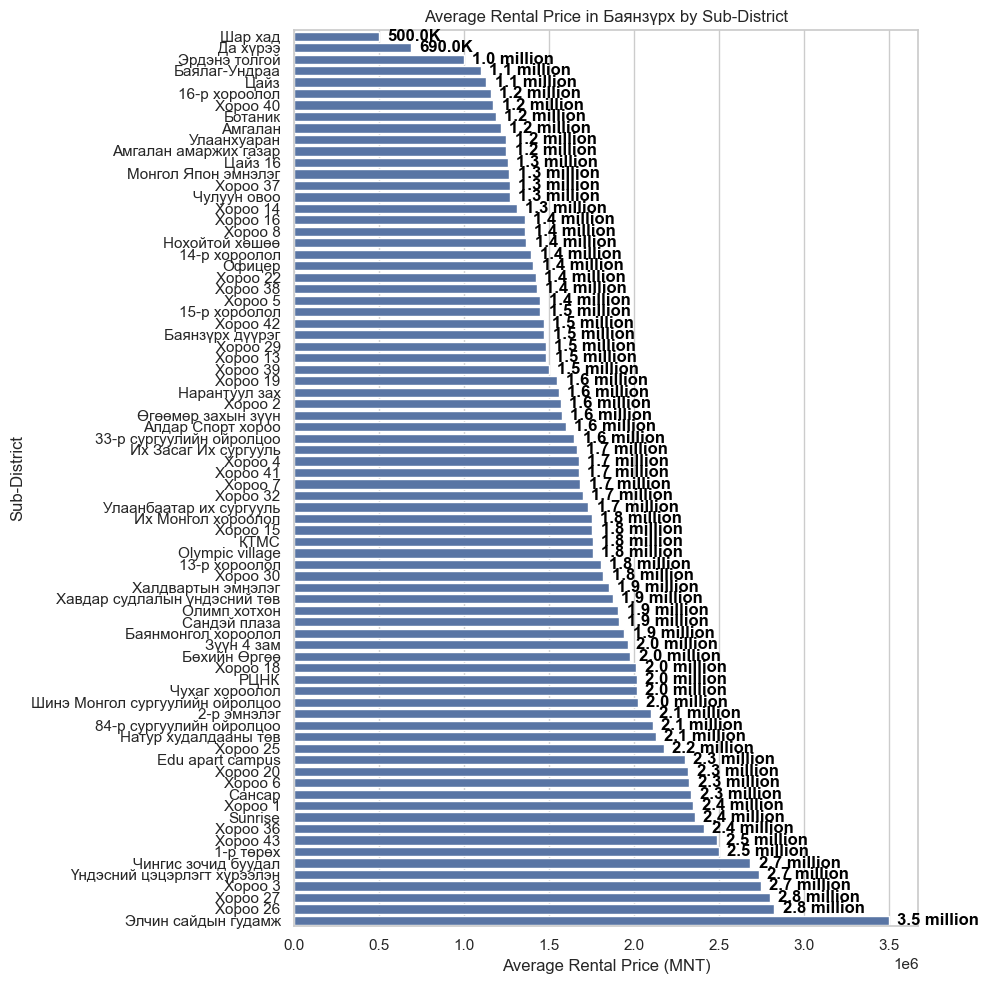

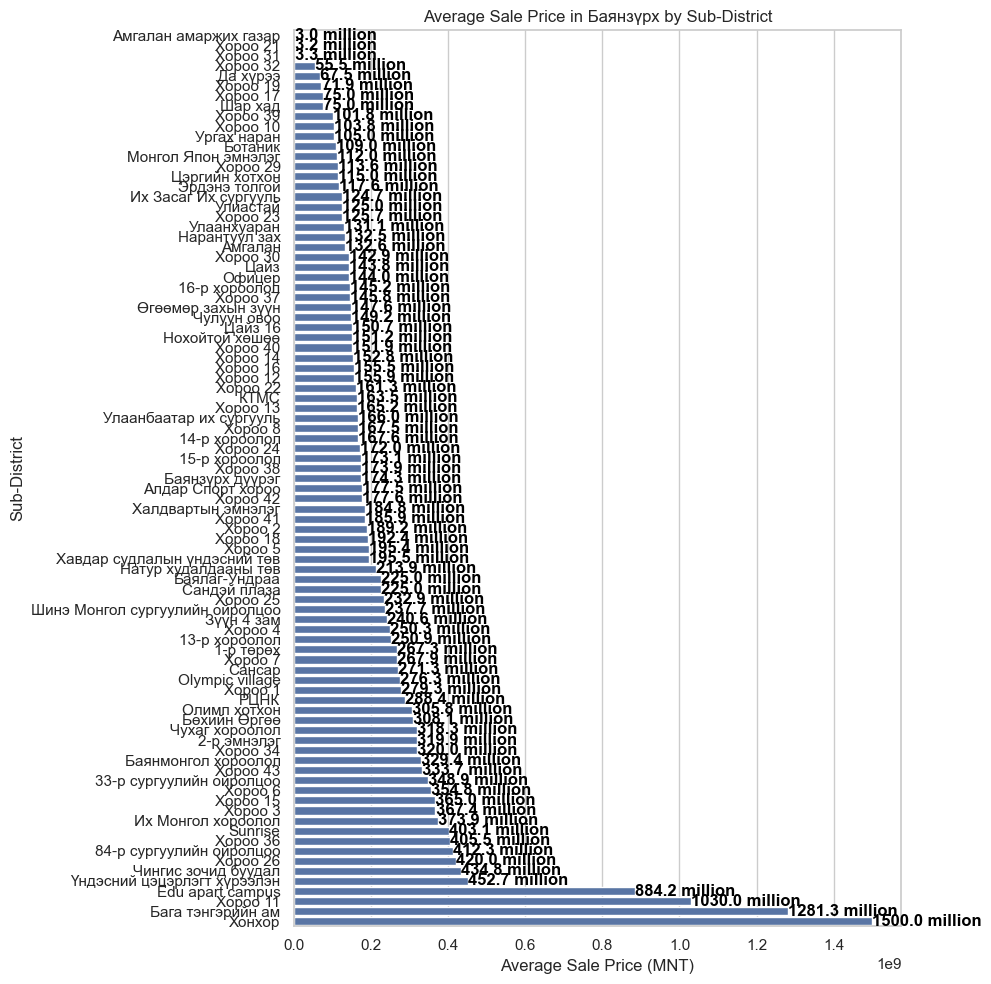

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming combined_df is your DataFrame
# Convert price to numeric if it's not already
combined_df['Үнэ'] = pd.to_numeric(combined_df['Үнэ'], errors='coerce')

# Function to format the price values
def format_price(price):
    if price >= 1_000_000:
        return f'{price / 1_000_000:.1f} million'  # Format to millions
    elif price >= 1_000:
        return f'{price / 1_000:.1f}K'  # Format to thousands
    else:
        return f'{price:.0f}'  # Return as-is for lower values

# Function to filter by district and type (Rental or Sale) and plot the chart
def plot_price_by_subdistrict(district, listing_type='Rental'):
    # Filter the data for the chosen listing type ('Rental' or 'Sale')
    filtered_df = combined_df[(combined_df['District'] == district) & (combined_df['Type'] == listing_type)]
    
    # Group by Sub-District and calculate the average price
    avg_price_by_subdistrict = filtered_df.groupby('Sub-District')['Үнэ'].mean().sort_values()

    # Check if we have any sub-districts to plot
    if len(avg_price_by_subdistrict) == 0:
        print(f"No data available for district: {district} with {listing_type} listings.")
        return
    
    # Apply formatting to the prices
    formatted_prices = avg_price_by_subdistrict.apply(format_price)

    # Plot the average price by sub-district
    plt.figure(figsize=(10, 10))
    sns.barplot(x=avg_price_by_subdistrict.values, y=avg_price_by_subdistrict.index, orient='h')
    
    # Add the actual price values (formatted)
    for i, v in enumerate(avg_price_by_subdistrict.values):
        plt.text(v + 50000, i, format_price(v), va='center', color='black', fontweight='bold')

    # Set title and labels
    plt.title(f'Average {listing_type} Price in {district} by Sub-District')
    plt.xlabel(f'Average {listing_type} Price (MNT)')
    plt.ylabel('Sub-District')
    plt.tight_layout()
    plt.show()

# Example usage:
# Plot rental prices for 'Баянзүрх' district
plot_price_by_subdistrict('Баянзүрх', listing_type='Rental')

# Plot sales prices for 'Баянзүрх' district
plot_price_by_subdistrict('Баянзүрх', listing_type='Sale')


## Preparing Data


In [48]:
buying_df

,Шал,Тагт,Гараж,Цонх,Хаалга,Цонхнытоо,Барилгынявц,Ашиглалтандорсонон,Барилгындавхар,Талбай,...,Type,Fixed Posted Date,District,Sub-District,PrimaryDistrict,Талбай_m2,price_per_m2,PrimaryDistrict1,PrimaryDistrict2,PrimaryKhoroo
10793,Паркет,1 тагттай,Байхгүй,Вакум,Төмөр,Ашиглалтад орсон,NaN,NaN,10.0,77.66 м²,...,Sale,2025-04-16 16:52:00.945016,Хан-Уул,Хороо 11,Хан-Уул,77.66,3.347927e+06,Хан-Уул,Хан-Уул,Хороо 11
10794,Паркет,1 тагттай,Байгаа,Төмөр вакум,Бүргэд,Ашиглалтад орсон,NaN,NaN,16.0,166.0 м²,...,Sale,2025-04-16 16:52:00.945030,Хан-Уул,River Garden,Хан-Уул,166.00,9.036145e+06,Хан-Уул,River Garden,None
10795,Паркет,2 тагттай,Байхгүй,Вакум,Бүргэд,Ашиглалтад орсон,NaN,NaN,17.0,117.83 м²,...,Sale,2025-04-16 16:52:00.945038,Хан-Уул,Хүннү,Хан-Уул,117.83,6.492404e+06,Хан-Уул,Хүннү,None
10796,Паркет,1 тагттай,Байхгүй,Вакум,Бүргэд,Ашиглалтад орсон,NaN,NaN,6.0,33.0 м²,...,Sale,2025-04-16 16:52:00.945046,Хан-Уул,Яармаг,Хан-Уул,33.00,2.741667e+06,Хан-Уул,Яармаг,None
10797,Паркет,2 тагттай,Байхгүй,Вакум,Бүргэд,Ашиглалтад орсон,NaN,NaN,9.0,78.0 м²,...,Sale,2025-04-16 16:52:00.945053,Баянгол,4 хороолол,Баянгол,78.00,3.076923e+06,Баянгол,3,4 хороолол
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22183,Паркет,1 тагттай,Байхгүй,Вакум,Бүргэд,Ашиглалтад орсон,NaN,NaN,9.0,34.04 м²,...,Sale,2025-03-09 17:56:00.000000,Баянзүрх,Амгалан,Баянзүрх,34.04,4.083431e+06,Баянзүрх,Амгалан,None
22184,Паркет,2 тагттай,Байхгүй,Вакум,Төмөр,Ашиглалтад орсон,NaN,NaN,5.0,83.0 м²,...,Sale,2025-03-07 16:44:00.000000,Хан-Уул,Яармаг,Хан-Уул,83.00,4.600000e+06,Хан-Уул,Яармаг,None
22185,Паркет,1 тагттай,Байгаа,Вакум,Бүргэд,Ашиглалтад орсон,NaN,NaN,9.0,209.0 м²,...,Sale,2025-03-06 14:56:00.000000,Хан-Уул,UB Town,Хан-Уул,209.00,2.822967e+06,Хан-Уул,UB Town,None
22186,Паркет,1 тагттай,Байгаа,Вакум,Бүргэд,Ашиглалтад орсон,NaN,NaN,16.0,64.2 м²,...,Sale,2025-03-05 11:03:00.000000,Баянзүрх,Хороо 26,Баянзүрх,64.20,4.439252e+06,Баянзүрх,Баянзүрх,Хороо 26


In [43]:
print(f"Average price: {df['Үнэ'].mean():,.0f}₮")


Average price: 322,141,490₮


In [ ]:
pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as XGBRegressor
from sklearn.inspection import permutation_importance
import re

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)


# Clean and transform the data
def clean_data(df):
    """Clean and prepare the dataset for analysis"""
    # Make a copy to avoid modifying the original
    df_clean = buying_df.copy()
    
    # Convert price to numeric (remove non-numeric characters if needed)
    if 'Үнэ' in df_clean.columns:
        df_clean['Price'] = pd.to_numeric(df_clean['Үнэ'], errors='coerce')
    
    # Convert area to numeric
    if 'Талбай' in df_clean.columns:
        df_clean['Area'] = df_clean['Талбай'].str.extract('(\d+\.?\d*)').astype(float)
    
    # Extract number of rooms
    if 'ӨрөөнийТоо' in df_clean.columns:
        df_clean['Rooms'] = df_clean['ӨрөөнийТоо'].str.extract('(\d+)').astype(float)
    
    # Extract floor number and total floors
    if 'Барилгындавхар' in df_clean.columns and 'Хэдэндавхарт' in df_clean.columns:
        df_clean['TotalFloors'] = pd.to_numeric(df_clean['Барилгындавхар'], errors='coerce')
        df_clean['Floor'] = pd.to_numeric(df_clean['Хэдэндавхарт'], errors='coerce')
    
    # Location indicators (district and sub-district)
    if 'District' in df_clean.columns:
        df_clean['District_Clean'] = df_clean['District']
    
    if 'Sub-District' in df_clean.columns:
        df_clean['SubDistrict_Clean'] = df_clean['Sub-District']
    
    # Feature for balcony (Тагт)
    if 'Тагт' in df_clean.columns:
        df_clean['HasBalcony'] = np.where(df_clean['Тагт'] == 'Байхгүй', 0, 1)
    
    # Extract year from posting date if available
    date_columns = [col for col in df_clean.columns if 'date' in col.lower() or 'он' in col.lower()]
    if date_columns:
        try:
            df_clean['PostYear'] = pd.to_datetime(df_clean[date_columns[0]]).dt.year
        except:
            pass
    
    # Get relevant columns for analysis
    relevant_cols = ['Price', 'Area', 'Rooms', 'TotalFloors', 'Floor', 
                     'District_Clean', 'SubDistrict_Clean', 'HasBalcony']
    
    # Include columns that exist in the DataFrame
    analysis_cols = [col for col in relevant_cols if col in df_clean.columns]
    
    # Return cleaned data
    return df_clean[analysis_cols].dropna()

# Perform exploratory data analysis
def explore_data(df):
    """Conduct exploratory data analysis"""
    print("\n=== Exploratory Data Analysis ===")
    
    # Basic statistics
    print("\nBasic Statistics:")
    print(df.describe().T)
    
    # Check for correlations with price
    if 'Price' in df.columns:
        print("\nCorrelations with Price:")
        correlations = df.corr()['Price'].sort_values(ascending=False)
        print(correlations)
        
        # Visualize correlations
        plt.figure(figsize=(10, 6))
        sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
        plt.title('Correlation Matrix')
        plt.tight_layout()
        plt.savefig('correlation_matrix.png')
        plt.close()
        
        # Price vs Area scatter plot
        if 'Area' in df.columns:
            plt.figure(figsize=(10, 6))
            sns.scatterplot(x='Area', y='Price', data=df)
            plt.title('Price vs Area')
            plt.tight_layout()
            plt.savefig('price_vs_area.png')
            plt.close()
        
        # Price by District boxplot
        if 'District_Clean' in df.columns:
            plt.figure(figsize=(12, 6))
            sns.boxplot(x='District_Clean', y='Price', data=df)
            plt.title('Price by District')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig('price_by_district.png')
            plt.close()
        
        # Price vs Rooms boxplot
        if 'Rooms' in df.columns:
            plt.figure(figsize=(10, 6))
            sns.boxplot(x='Rooms', y='Price', data=df)
            plt.title('Price by Number of Rooms')
            plt.tight_layout()
            plt.savefig('price_by_rooms.png')
            plt.close()

# Build and evaluate models
def build_models(df):
    """Build and evaluate pricing models"""
    print("\n=== Model Building and Feature Importance ===")
    
    # Define X and y
    if 'Price' not in df.columns:
        print("Price column not found in dataset")
        return
    
    # Copy the dataframe to avoid modifying the original
    model_df = df.copy()
    
    # Get numeric and categorical columns
    numeric_cols = model_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col != 'Price']
    
    categorical_cols = model_df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    X = model_df.drop('Price', axis=1)
    y = model_df['Price']
    
    # Print feature list
    print(f"\nFeatures used in the model: {X.columns.tolist()}")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create preprocessing steps
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    
    # Only use categorical transformer if categorical columns exist
    preprocessor = None
    if len(categorical_cols) > 0:
        categorical_transformer = Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])
        
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_cols),
                ('cat', categorical_transformer, categorical_cols)
            ])
    else:
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_cols)
            ])
    
    # Linear Regression
    lr_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])
    
    # Random Forest
    rf_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
    
    # Train and evaluate Linear Regression
    print("\nTraining Linear Regression model...")
    lr_pipeline.fit(X_train, y_train)
    y_pred_lr = lr_pipeline.predict(X_test)
    
    print("\nLinear Regression Results:")
    rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
    r2_lr = r2_score(y_test, y_pred_lr)
    print(f"RMSE: {rmse_lr:.2f}")
    print(f"R²: {r2_lr:.4f}")
    
    # Train and evaluate Random Forest
    print("\nTraining Random Forest model...")
    rf_pipeline.fit(X_train, y_train)
    y_pred_rf = rf_pipeline.predict(X_test)
    
    print("\nRandom Forest Results:")
    rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
    r2_rf = r2_score(y_test, y_pred_rf)
    print(f"RMSE: {rmse_rf:.2f}")
    print(f"R²: {r2_rf:.4f}")
    
    # Feature importance from Random Forest
    rf_model = rf_pipeline.named_steps['regressor']
    
    # Handle feature names for both numerical and categorical features
    if len(categorical_cols) > 0:
        # Get feature names from preprocessor
        ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
        feature_names = (
            numeric_cols +
            ohe.get_feature_names_out(categorical_cols).tolist()
        )
    else:
        feature_names = numeric_cols
    
    # Get feature importances
    if hasattr(rf_model, 'feature_importances_'):
        # Extract feature importance
        importances = rf_model.feature_importances_
        
        # Create DataFrame of feature importances
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        })
        
        # Sort by importance
        feature_importance = feature_importance.sort_values('Importance', ascending=False)
        
        print("\nFeature Importance (Random Forest):")
        print(feature_importance)
        
        # Visualize feature importance
        plt.figure(figsize=(10, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
        plt.title('Top 10 Most Important Features for Price Prediction')
        plt.tight_layout()
        plt.savefig('feature_importance.png')
        plt.close()
    
    # Permutation importance (works with any model)
    print("\nCalculating permutation importance...")
    try:
        perm_importance = permutation_importance(
            rf_pipeline, X_test, y_test, n_repeats=10, random_state=42
        )
        
        # Create DataFrame for permutation importance
        perm_importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': perm_importance.importances_mean
        }).sort_values('Importance', ascending=False)
        
        print("\nPermutation Importance:")
        print(perm_importance_df)
        
        # Visualize permutation importance
        plt.figure(figsize=(10, 8))
        sns.barplot(x='Importance', y='Feature', data=perm_importance_df.head(10))
        plt.title('Top 10 Features by Permutation Importance')
        plt.tight_layout()
        plt.savefig('permutation_importance.png')
        plt.close()
    except Exception as e:
        print(f"Error calculating permutation importance: {e}")

def analyze_factors_with_price(data_path):
    """Main function to analyze which factors most affect price"""
    print("=== Analyzing Real Estate Price Factors ===")
    
    # Load data
    df = load_data(data_path)
    if df is None:
        print("Failed to load data. Please check the file path.")
        return
    
    # Display data overview
    print("\nData Overview:")
    print(f"Shape: {df.shape}")
    print("\nColumns:")
    for col in df.columns:
        print(f"- {col}")
    
    # Clean data
    df_clean = clean_data(df)
    print(f"\nCleaned data shape: {df_clean.shape}")
    
    # Check if we have enough data for analysis
    if len(df_clean) < 2:
        print("\nWarning: Not enough data points for meaningful analysis after cleaning.")
        print("Please provide more data or adjust the cleaning process.")
        return
    
    # Explore data
    explore_data(df_clean)
    
    # Build models and identify important features
    build_models(df_clean)
    
    print("\n=== Analysis Complete ===")
    print("Check the saved plots for visualizations of the results.")
    print("\nSummary of findings:")
    print("1. The most important factors affecting property prices are shown in the feature importance plots.")
    print("2. These factors are ranked by their impact on predicting property prices.")
    print("3. The correlation matrix shows the relationships between different factors and price.")

# Example usage
if __name__ == "__main__":
    # Replace with your actual data file path
    data_path = "mongolian_real_estate_data.csv"
    analyze_factors_with_price(data_path)

# Model 

1. Price Prediction Tool (For Renters & Buyers)
2. Price Classification (For Renters & Buyers)
3. Price Trend Analysis (For Renters & Buyers)
4. District/Sub-District Comparison (For Buyers/Renters)
5. Anomaly Detection (For Buyers/Renters and Real Estate Agents)
6. Market Segmentation (For Real Estate Agents)


# Tools 